In [1]:
# RSI Strategy using python

## RSI > 70 => Overbought, sold sell signal ; RSI < 30 => Oversold, buy signal

"""
RSI Strategy using yfinance + matplotlib
---------------------------------------
Core idea:
- RSI > 70  -> Overbought -> Sell signal
- RSI < 30  -> Oversold   -> Buy signal

What this script does:
1) Download historical price data from Yahoo Finance (yfinance)
2) Compute RSI (Wilder's smoothing, common default)
3) Generate buy/sell signals based on RSI thresholds
4) Plot:
   - Price chart with buy/sell markers
   - RSI chart with 30/70 lines (and optional 50 midline)
"""

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

![alt text](<images\RSI_Strategy_使用技巧.jpg>)

<img src="images/RSI_Strategy_使用技巧.jpg" width="300" height="auto">

In [ ]:
# =========================
# 1) RSI calculation helper
# =========================
def compute_rsi(close: pd.Series, window: int = 14) -> pd.Series:
    """
    Compute RSI using Wilder's smoothing (EMA-like).
    
    Parameters
    ----------
    close : pd.Series
        Series of close prices.
    window : int
        RSI lookback period. Common values: 14 (default), 9 (short-term).
    
    Returns
    -------
    pd.Series
        RSI values (0-100).
    """
    # Price changes between consecutive days
    delta = close.diff()

    # Separate gains and losses
    gain = delta.where(delta > 0, 0.0)
    loss = (-delta).where(delta < 0, 0.0)

    # Wilder's smoothing uses alpha = 1/window
    # Using ewm with adjust=False is the typical implementation
    avg_gain = gain.ewm(alpha=1 / window, adjust=False).mean()
    avg_loss = loss.ewm(alpha=1 / window, adjust=False).mean()

    # RS and RSI
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    return rsi


# ==========================================
# 2) Strategy: build signals based on RSI
# ==========================================
def rsi_strategy(
    ticker: str,
    start_date: str,
    end_date: str,
    window: int = 14,
    buy_level: float = 30,
    sell_level: float = 70,
) -> pd.DataFrame:
    """
    Download data and compute RSI + buy/sell signals.

    Buy signal:
        RSI < buy_level  -> 1
    Sell signal:
        RSI > sell_level -> -1

    Returns a DataFrame with:
    - Close
    - RSI
    - Buy_Signal (1/0)
    - Sell_Signal (-1/0)
    """
    # Download historical data
    df = yf.download(ticker, start=start_date, end=end_date, auto_adjust=False)

    if df is None or df.empty:
        raise ValueError(f"No data returned for ticker: {ticker}")

    # Keep only Close and ensure column is named 'Close'
    if isinstance(df.columns, pd.MultiIndex):
        # Some environments return multi-index columns
        df.columns = df.columns.get_level_values(0)

    df = df.copy()
    df = df[["Close"]].dropna()

    # Compute RSI
    df["RSI"] = compute_rsi(df["Close"], window=window)

    # Generate signals
    df["Buy_Signal"] = np.where(df["RSI"] < buy_level, 1, 0)
    df["Sell_Signal"] = np.where(df["RSI"] > sell_level, -1, 0)

    return df


# ==========================
# 3) Plotting helper
# ==========================
def plot_price_and_rsi(
    df: pd.DataFrame,
    ticker: str,
    buy_level: float = 30,
    sell_level: float = 70,
    show_midline: bool = True,
):
    """
    Plot:
    - Price with buy/sell markers
    - RSI with threshold lines
    """
    # Prepare buy/sell points for plotting
    buy_points = df[df["Buy_Signal"] == 1]
    sell_points = df[df["Sell_Signal"] == -1]

    # Create 2-row figure (Price on top, RSI below)
    fig = plt.figure(figsize=(12, 8))

    # --- Price subplot ---
    ax1 = plt.subplot(2, 1, 1)
    ax1.plot(df.index, df["Close"], linewidth=1.5, label="Close Price")

    # Plot buy markers (green triangle up) and sell markers (red triangle down)
    ax1.scatter(buy_points.index, buy_points["Close"], marker="^", s=80, label="Buy (RSI<30)")
    ax1.scatter(sell_points.index, sell_points["Close"], marker="v", s=80, label="Sell (RSI>70)")

    ax1.set_title(f"{ticker} Price with RSI Signals")
    ax1.set_ylabel("Price")
    ax1.grid(True, alpha=0.3)
    ax1.legend(loc="best")

    # --- RSI subplot ---
    ax2 = plt.subplot(2, 1, 2, sharex=ax1)
    ax2.plot(df.index, df["RSI"], linewidth=1.5, label="RSI")

    # RSI threshold lines
    ax2.axhline(sell_level, linestyle="--", linewidth=1.2, label=f"Overbought ({sell_level})")
    ax2.axhline(buy_level, linestyle="--", linewidth=1.2, label=f"Oversold ({buy_level})")

    # Optional midline at 50
    if show_midline:
        ax2.axhline(50, linestyle=":", linewidth=1.0, label="Midline (50)")

    ax2.set_title("RSI Indicator")
    ax2.set_ylabel("RSI (0-100)")
    ax2.set_xlabel("Date")
    ax2.set_ylim(0, 100)
    ax2.grid(True, alpha=0.3)
    ax2.legend(loc="best")

    plt.tight_layout()
    plt.show()



[*********************100%***********************]  1 of 1 completed

Price            Close        RSI  Buy_Signal  Sell_Signal
Date                                                      
2024-11-15  225.000000  46.169380           0            0
2024-11-18  228.020004  51.542651           0            0
2024-11-19  228.279999  51.986985           0            0
2024-11-20  229.000000  53.265029           0            0
2024-11-21  228.520004  52.266188           0            0
2024-11-22  229.869995  54.831656           0            0
2024-11-25  232.869995  59.979213           0            0
2024-11-26  235.059998  63.269973           0            0
2024-11-27  234.929993  62.939123           0            0
2024-11-29  237.330002  66.429186           0            0


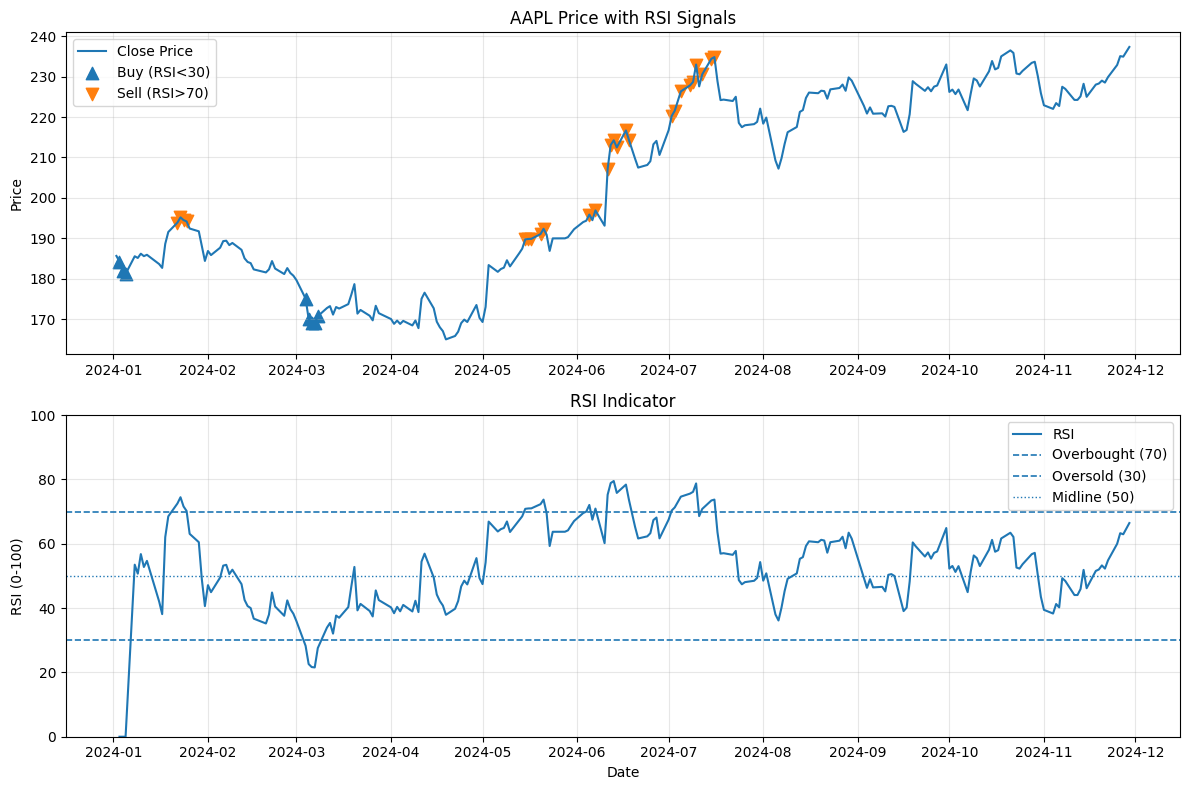

In [3]:

# ==========================
# 4) Main (example usage)
# ==========================
if __name__ == "__main__":
    # ---- User settings ----
    # Examples:
    # US stocks: "AAPL", "MSFT", "NVDA"
    # ETFs: "SPY", "QQQ"
    # Crypto (Yahoo Finance format): "BTC-USD", "ETH-USD"
    ticker = "AAPL"

    # Time range
    start_date = "2024-01-01"
    end_date = "2024-12-01"

    # RSI params
    window = 14
    buy_level = 30
    sell_level = 70

    # ---- Run strategy ----
    data = rsi_strategy(
        ticker=ticker,
        start_date=start_date,
        end_date=end_date,
        window=window,
        buy_level=buy_level,
        sell_level=sell_level,
    )

    # Print latest rows (similar to your screenshot style)
    # Columns shown: date index, Close, RSI, Buy_Signal, Sell_Signal
    print(data[["Close", "RSI", "Buy_Signal", "Sell_Signal"]].tail(10))

    # ---- Plot ----
    plot_price_and_rsi(
        df=data,
        ticker=ticker,
        buy_level=buy_level,
        sell_level=sell_level,
        show_midline=True,
    )


[*********************100%***********************]  1 of 1 completed

Price            Close        RSI  Buy_Signal  Sell_Signal
Date                                                      
2024-11-15  225.000000  46.169380           0            0
2024-11-18  228.020004  51.542651           0            0
2024-11-19  228.279999  51.986985           0            0
2024-11-20  229.000000  53.265029           0            0
2024-11-21  228.520004  52.266188           0            0
2024-11-22  229.869995  54.831656           0            0
2024-11-25  232.869995  59.979213           0            0
2024-11-26  235.059998  63.269973           0            0
2024-11-27  234.929993  62.939123           0            0
2024-11-29  237.330002  66.429186           0            0


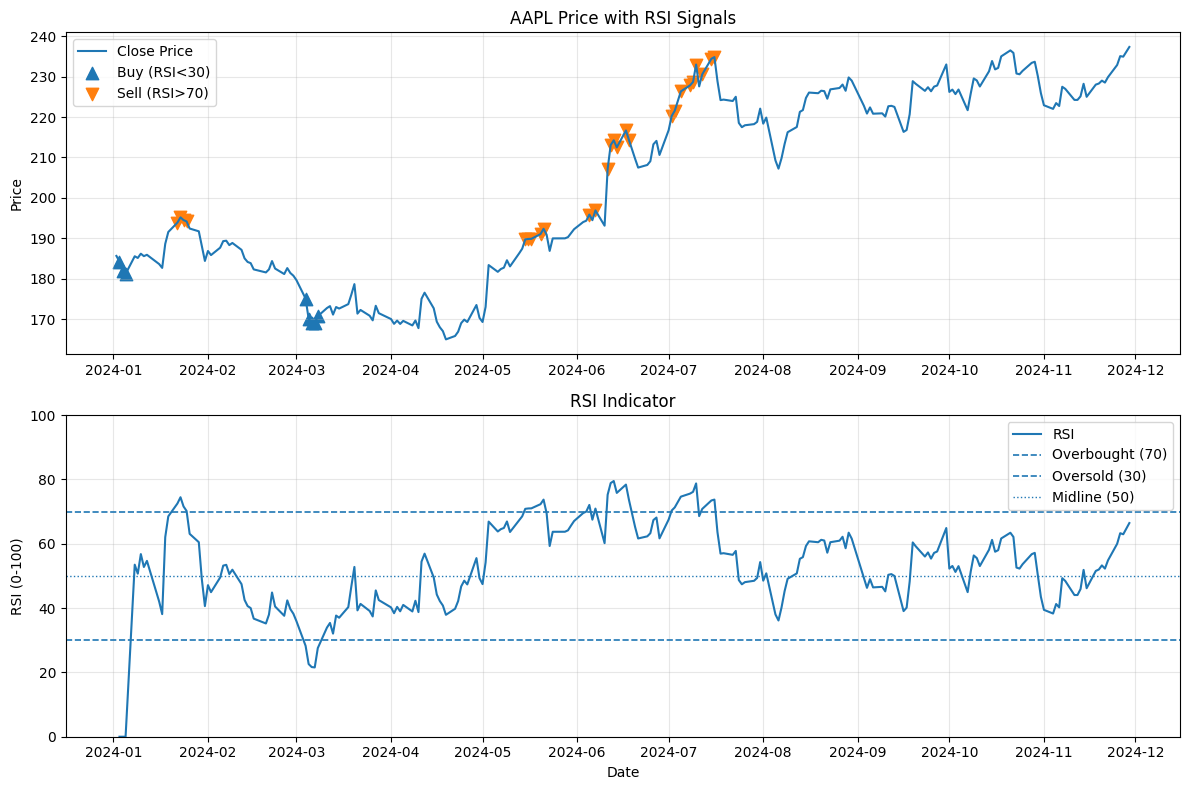

In [4]:

# ==========================
# 4) example usage
# ==========================

ticker = "AAPL"

# Time range
start_date = "2024-01-01"
end_date = "2024-12-01"

# RSI params
window = 14
buy_level = 30
sell_level = 70

# ---- Run strategy ----
data = rsi_strategy(
        ticker=ticker,
        start_date=start_date,
        end_date=end_date,
        window=window,
        buy_level=buy_level,
        sell_level=sell_level,
)

# Print latest rows (similar to your screenshot style)
# Columns shown: date index, Close, RSI, Buy_Signal, Sell_Signal
print(data[["Close", "RSI", "Buy_Signal", "Sell_Signal"]].tail(10))

# ---- Plot ----
plot_price_and_rsi(
        df=data,
        ticker=ticker,
        buy_level=buy_level,
        sell_level=sell_level,
        show_midline=True,
    )
